In [1]:
'''
Import the necessary libraries:
os: to work with file directories
numpy: to work with arrays
pylab:
glob: to find for particular files
scipy.io: to load and save .mat files
data_import: to access the .txt data
rsync: to align the data
'''

import os
import numpy as np
#import pylab as plt
import glob as glob
from scipy.io import loadmat, savemat
import data_import as di
from rsync import Rsync_aligner
from tkinter import *
from tkinter import filedialog

In [2]:
# Define the samping frequency
sampling_frequency = 30e3

In [3]:
# Define a function to
directory_object = Tk()
directory_object.withdraw()
project_file_directory = filedialog.askdirectory()

In [4]:
project_file_directory
project_file_directory = os.path.join(project_file_directory,'SpikeStuff')

In [5]:
all_folders_names = next(os.walk(project_file_directory))[1]
print('There are a total of', (len(all_folders_names)), 'groups. Remember that python uses zero indexing')

There are a total of 2 groups. Remember that python uses zero indexing


In [6]:
all_folders_names

['CTZ', 'No_CTZ']

In [7]:
def check_if_directory_exists(directory_fun):
    if not os.path.isdir(directory_fun):
        os.mkdir(directory_fun)

Loading group index value 0 with file name: CTZ
There are 12 recordings in CTZ
Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_2303_1/ctz_2303_emx_optostim-2023-02-04-162455.txt
Importing data file: ctz_2303_emx_optostim-2023-02-04-162455.txt
Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_2303_1/MUA/allData/timestamp_ms_nev.mat
ctz_2303_1: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 188 elements and timestamp_ms_nev has 188 elements.
Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_2874_2/ctz_2874_emx_led_rec2_redo-2022-11-04-194218.txt
Importing data file: ctz_2874_emx_led_rec2_redo-2022-11-04-194218.txt
Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_2874_2/MUA/allData/timestamp_ms_nev.mat


/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)


ctz_2874_2: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 173 elements and timestamp_ms_nev has 170 elements.
Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_2874_1/ctz_2874_emx_led_redo-2022-11-04-150655.txt
Importing data file: ctz_2874_emx_led_redo-2022-11-04-150655.txt
Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_2874_1/MUA/allData/timestamp_ms_nev.mat
ctz_2874_1: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 198 elements and timestamp_ms_nev has 198 elements.
Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_3835/ctz_3835_led-2022-10-25-181736.txt
Importing data file: ctz_3835_led-2022-10-25-181736.txt


/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)


Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_3835/MUA/allData/timestamp_ms_nev.mat
ctz_3835: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 175 elements and timestamp_ms_nev has 175 elements.
Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_3836/ctz_3836_opto-2022-10-24-182941.txt
Importing data file: ctz_3836_opto-2022-10-24-182941.txt
Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_3836/MUA/allData/timestamp_ms_nev.mat


/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)


ctz_3836: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 181 elements and timestamp_ms_nev has 181 elements.
Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_3942_1/ctz_3942_emx_optostim-2023-01-19-174607.txt
Importing data file: ctz_3942_emx_optostim-2023-01-19-174607.txt
Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_3942_1/MUA/allData/timestamp_ms_nev.mat


/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)


ctz_3942_1: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 182 elements and timestamp_ms_nev has 182 elements.
Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_3942_2/ctz_3942_emx_optostim2-2023-01-19-212952.txt
Importing data file: ctz_3942_emx_optostim2-2023-01-19-212952.txt
Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_3942_2/MUA/allData/timestamp_ms_nev.mat
ctz_3942_2: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 177 elements and timestamp_ms_nev has 177 elements.
Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_3960/ctz_3960_emx_optostim-2022-11-15-201142.txt
Importing data file: ctz_3960_emx_optostim-2022-11-15-201142.txt


/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)


Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_3960/MUA/allData/timestamp_ms_nev.mat
ctz_3960: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 189 elements and timestamp_ms_nev has 189 elements.
Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_alt1/ctz_alt1_emx_optostim-2022-11-17-165904.txt
Importing data file: ctz_alt1_emx_optostim-2022-11-17-165904.txt
Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_alt1/MUA/allData/timestamp_ms_nev.mat


/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)


ctz_alt1: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 186 elements and timestamp_ms_nev has 186 elements.
Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_2303_2/ctz_2303_emx_optostim2-2023-02-04-203535.txt
Importing data file: ctz_2303_emx_optostim2-2023-02-04-203535.txt
Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_2303_2/MUA/allData/timestamp_ms_nev.mat
ctz_2303_2: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 176 elements and timestamp_ms_nev has 176 elements.
Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_3689_2/ctz_3698_emx_optostim2-2023-02-23-005330.txt
Importing data file: ctz_3698_emx_optostim2-2023-02-23-005330.txt


/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)


Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_3689_2/MUA/allData/timestamp_ms_nev.mat
ctz_3689_2: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 174 elements and timestamp_ms_nev has 174 elements.
Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_3689_1/ctz_3698_emx_optostim-2023-02-22-211216.txt
Importing data file: ctz_3698_emx_optostim-2023-02-22-211216.txt


/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)


Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/CTZ/ctz_3689_1/MUA/allData/timestamp_ms_nev.mat
ctz_3689_1: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 201 elements and timestamp_ms_nev has 201 elements.
-------------------------------------------------------------------------------------------------------
Loading group index value 1 with file name: No_CTZ
There are 12 recordings in No_CTZ
Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/No_CTZ/veh_3062_1/veh_3602_emx_led-2022-11-01-152245.txt
Importing data file: veh_3602_emx_led-2022-11-01-152245.txt
Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/No_CTZ/veh_3062_1/MUA/allData/timestamp_ms_nev.mat
veh_3062_1: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 184 elements and timestamp_ms_nev has 184 elements.
Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/Spik

/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)


Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/No_CTZ/veh_3062_2/MUA/allData/timestamp_ms_nev.mat
veh_3062_2: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 179 elements and timestamp_ms_nev has 179 elements.
Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/No_CTZ/veh_3062_3/veh_3602_emx_led_rec3-2022-11-01-224054.txt
Importing data file: veh_3602_emx_led_rec3-2022-11-01-224054.txt


/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)


Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/No_CTZ/veh_3062_3/MUA/allData/timestamp_ms_nev.mat
veh_3062_3: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 187 elements and timestamp_ms_nev has 187 elements.
Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/No_CTZ/veh_3141_1/veh_3141_emx_optostim-2023-01-27-172729.txt
Importing data file: veh_3141_emx_optostim-2023-01-27-172729.txt
Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/No_CTZ/veh_3141_1/MUA/allData/timestamp_ms_nev.mat
veh_3141_1: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 187 elements and timestamp_ms_nev has 187 elements.


/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)


Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/No_CTZ/veh_3141_2/veh_3141_emx_optostim2-2023-01-27-210836.txt
Importing data file: veh_3141_emx_optostim2-2023-01-27-210836.txt
Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/No_CTZ/veh_3141_2/MUA/allData/timestamp_ms_nev.mat
veh_3141_2: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 177 elements and timestamp_ms_nev has 177 elements.
Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/No_CTZ/veh_3142_1/veh_3142_emx_optostim-2023-01-31-170915.txt
Importing data file: veh_3142_emx_optostim-2023-01-31-170915.txt
Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/No_CTZ/veh_3142_1/MUA/allData/timestamp_ms_nev.mat
veh_3142_1: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 178 elements and timestamp_ms_nev has 178 elements.
Extracting data from file path: /home/cr

/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)


Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/No_CTZ/veh_3142_2/MUA/allData/timestamp_ms_nev.mat
veh_3142_2: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 193 elements and timestamp_ms_nev has 193 elements.
Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/No_CTZ/veh_3143_1/veh_3143_emx_optostim-2023-01-24-204429.txt
Importing data file: veh_3143_emx_optostim-2023-01-24-204429.txt
Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/No_CTZ/veh_3143_1/MUA/allData/timestamp_ms_nev.mat


/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)


veh_3143_1: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 181 elements and timestamp_ms_nev has 181 elements.
Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/No_CTZ/veh_3143_2/veh_3143_emx_optostim2-2023-01-25-010056.txt
Importing data file: veh_3143_emx_optostim2-2023-01-25-010056.txt
Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/No_CTZ/veh_3143_2/MUA/allData/timestamp_ms_nev.mat


/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)


veh_3143_2: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 170 elements and timestamp_ms_nev has 170 elements.
Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/No_CTZ/veh_2836_1/veh_2836_emx_optostim-2023-06-22-212955.txt
Importing data file: veh_2836_emx_optostim-2023-06-22-212955.txt
Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/No_CTZ/veh_2836_1/MUA/allData/timestamp_ms_nev.mat


/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)


veh_2836_1: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 181 elements and timestamp_ms_nev has 181 elements.
Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/No_CTZ/veh_2836_2/veh_2836_emx_optostim2-2023-06-23-012431.txt
Importing data file: veh_2836_emx_optostim2-2023-06-23-012431.txt
Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/No_CTZ/veh_2836_2/MUA/allData/timestamp_ms_nev.mat


/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)


veh_2836_2: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 187 elements and timestamp_ms_nev has 187 elements.
Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/No_CTZ/veh_2835/veh_2835_emx_optostim-2023-06-27-164721.txt
Importing data file: veh_2835_emx_optostim-2023-06-27-164721.txt
Extracting from /home/cresp1el-local/Documents/MATLAB/Data/SfN_Emx/LED/SpikeStuff/No_CTZ/veh_2835/MUA/allData/timestamp_ms_nev.mat


/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)


veh_2835: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 180 elements and timestamp_ms_nev has 180 elements.
-------------------------------------------------------------------------------------------------------


/tmp/ipykernel_505252/1664475870.py:70: RuntimeWarning: invalid value encountered in cast
  onsets = ephys_aligner.A_to_B(reward_times).astype(int)
/tmp/ipykernel_505252/1664475870.py:73: RuntimeWarning: invalid value encountered in cast
  offsets = ephys_aligner.A_to_B(reward_times).astype(int)


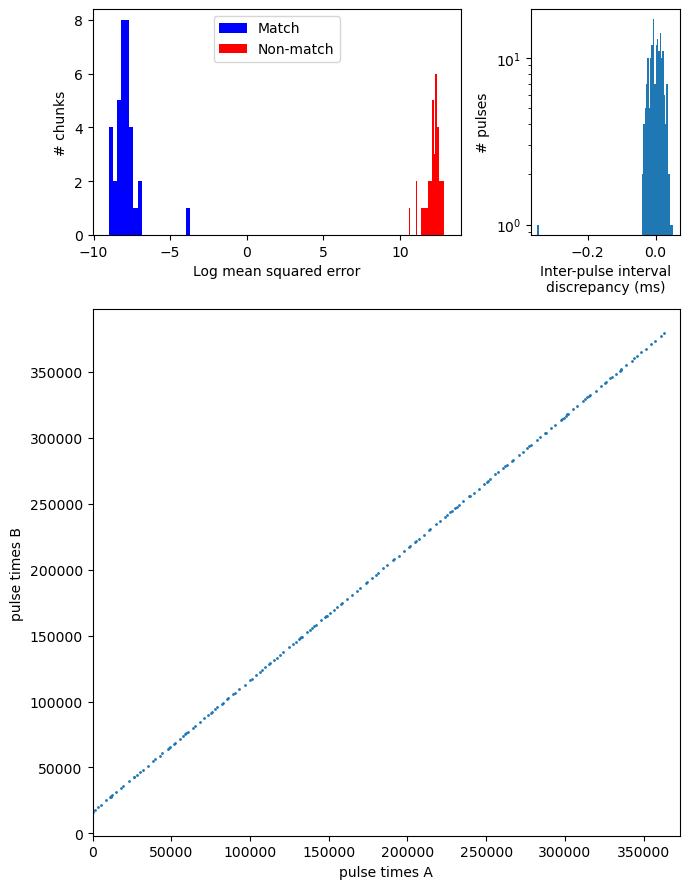

In [12]:
for n_group in range(len(all_folders_names)): #iterate across groups 
    
    print('Loading group index value', n_group, 'with file name:', all_folders_names[n_group])

    groupDir = project_file_directory + "/" + all_folders_names[n_group]
    numRecording = len(next(os.walk(groupDir))[1])
    all_rec_names = next(os.walk(groupDir))[1]   
    
    print('There are', numRecording, 'recordings in', all_folders_names[n_group])
    
    for n_rec in range(len(all_rec_names)): #iterate across recordings within a group
        
        this_recording = groupDir + "/" + all_rec_names[n_rec] #directory path of recording 
        
        find_for_txt_file = this_recording + "/*.txt"
        txt_file_full_path = glob.glob(find_for_txt_file) 
        txt_file_full_path = ''.join(txt_file_full_path) #convert list into a string 
        
        print("Extracting data from file path: %s" % txt_file_full_path)
        
        file_directory_to_save_data = this_recording + "/MUA/allData/"
        
        PC_data = di.Session(txt_file_full_path, int_subject_IDs=False)
        
        session_events= PC_data.events
        session_times = PC_data.times
        session_print_lines = PC_data.print_lines
        
        savemat(file_directory_to_save_data + "session_events.mat", {"data": session_events})
        savemat(file_directory_to_save_data + "session_times.mat", {"data": session_times})
        savemat(file_directory_to_save_data + "session_print_lines.mat", {"data": session_print_lines})
        
        # Extract data from ".txt" file
        rsync_PC = PC_data.times["rsync"]
        stim_active_PC = PC_data.times["stim_active"]
        
        # Extract data from the ".nev" saved as a ".mat" file
        
        timestamp_nev_file_directory = this_recording + "/MUA/allData/timestamp_ms_nev.mat"
        
        print("Extracting from %s" %timestamp_nev_file_directory)
        timestamp_ms_dict = loadmat(timestamp_nev_file_directory)
        
        timestamp_ms_nev = timestamp_ms_dict["timestamp_ms"][0]
        
        timestamp_ms_nev = np.reshape(timestamp_ms_nev, (len(timestamp_ms_nev), ))
        
        if len(rsync_PC) == len(timestamp_ms_nev)/2:
                timestamp_ms_nev = timestamp_ms_nev[0::2]
        
        pulse_times_PC = rsync_PC
        pulse_timestamps_BR = timestamp_ms_nev
        
        try:
            ephys_aligner = Rsync_aligner(pulse_times_A=pulse_times_PC, pulse_times_B=pulse_timestamps_BR,
                        units_A="auto", units_B="auto", plot=True)
            print("%s: Rsync_PC and timestamp_ms_nev shapes are fine!" %all_rec_names[n_rec])
            print("Rsync has %d elements and timestamp_ms_nev has %d elements." 
                  %(len(rsync_PC), len(timestamp_ms_nev)))
            
        except:
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("%s: Check rsync_PC and timestamp_ms_nev shapes!" %all_rec_names[n_rec])
            print("Rsync has %d elements and timestamp_ms_nev has %d elements." 
                  %(len(rsync_PC), len(timestamp_ms_nev)))
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            
        num_trials = len(stim_active_PC)
        reward_times = PC_data.times['stim_active'][:num_trials]
        onsets = ephys_aligner.A_to_B(reward_times).astype(int)
        
        reward_times = PC_data.times['waiting_period'][:num_trials]
        offsets = ephys_aligner.A_to_B(reward_times).astype(int)
        
        ## comment add what Manny just said]Py control is initialized you get square shaped artifact
        if onsets[0] > offsets[0]:
            modified_onsets = onsets[:-1]
            modified_offsets = offsets[1:]
        
            all_timestamp_ms = np.zeros((len(modified_onsets), 3))

            all_timestamp_ms[:, 0] = modified_onsets # ms
            all_timestamp_ms[:, 1] = modified_offsets # ms
            
        else:
            all_timestamp_ms = np.zeros((len(onsets), 3))

            all_timestamp_ms[:, 0] = onsets # ms
            all_timestamp_ms[:, 1] = offsets # ms
        
        savemat(file_directory_to_save_data + 'without_frequency_timestamp_ms.mat', {'data': all_timestamp_ms})
            
    print("-------------------------------------------------------------------------------------------------------")